In [ ]:
!pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata

import time

np.random.seed(1234)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if str(device) == 'cuda': 
    print(torch.cuda.get_device_name())

cuda
Tesla T4


## Physics-informed Neural Networks

In [ ]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [ ]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, ic_bc, X_f, layers, lb, ub):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(ic_bc[:, 0:1]).float().to(device)
        self.v = torch.tensor(ic_bc[:, 1:2]).float().to(device)

        self.p = torch.tensor(ic_bc[:, 2:3]).float().to(device)
        self.s = torch.tensor(ic_bc[:, 3:4]).float().to(device)

        self.a = torch.tensor(ic_bc[:, 4:5]).float().to(device)
        self.b = torch.tensor(ic_bc[:, 5:6]).float().to(device)

        self.c = torch.tensor(ic_bc[:, 6:7]).float().to(device)
        self.d = torch.tensor(ic_bc[:, 7:8]).float().to(device)
        
        self.layers = layers

        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
        
    def net_u(self, x, t):  
        y = self.dnn(torch.cat([x, t], dim=1))
        return y
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        y = self.net_u(x, t)
        
        u = y[:, 0:1]
        v = y[:, 1:2]
        p = y[:, 2:3]
        s = y[:, 3:4]
        a = y[:, 4:5]
        b = y[:, 5:6]
        c = y[:, 6:7]
        d = y[:, 7:8]

        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]

        p_t = torch.autograd.grad(p, t, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]
        s_t = torch.autograd.grad(s, t, grad_outputs=torch.ones_like(s), retain_graph=True, create_graph=True)[0]

        a_t = torch.autograd.grad(a, t, grad_outputs=torch.ones_like(a), retain_graph=True, create_graph=True)[0]
        b_t = torch.autograd.grad(b, t, grad_outputs=torch.ones_like(b), retain_graph=True, create_graph=True)[0]

        c_t = torch.autograd.grad(c, t, grad_outputs=torch.ones_like(c), retain_graph=True, create_graph=True)[0]
        d_t = torch.autograd.grad(d, t, grad_outputs=torch.ones_like(d), retain_graph=True, create_graph=True)[0]

        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]

        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]
        s_x = torch.autograd.grad(s, x, grad_outputs=torch.ones_like(s), retain_graph=True, create_graph=True)[0]

        a_x = torch.autograd.grad(a, x, grad_outputs=torch.ones_like(a), retain_graph=True, create_graph=True)[0]
        b_x = torch.autograd.grad(b, x, grad_outputs=torch.ones_like(b), retain_graph=True, create_graph=True)[0]

        c_x = torch.autograd.grad(c, x, grad_outputs=torch.ones_like(c), retain_graph=True, create_graph=True)[0]
        d_x = torch.autograd.grad(d, x, grad_outputs=torch.ones_like(d), retain_graph=True, create_graph=True)[0]


        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), retain_graph=True, create_graph=True)[0]

        p_xx = torch.autograd.grad(p_x, x, grad_outputs=torch.ones_like(p_x), retain_graph=True, create_graph=True)[0]
        s_xx = torch.autograd.grad(s_x, x, grad_outputs=torch.ones_like(s_x), retain_graph=True, create_graph=True)[0]

        a_xx = torch.autograd.grad(a_x, x, grad_outputs=torch.ones_like(a_x), retain_graph=True, create_graph=True)[0]
        b_xx = torch.autograd.grad(b_x, x, grad_outputs=torch.ones_like(b_x), retain_graph=True, create_graph=True)[0]

        c_xx = torch.autograd.grad(c_x, x, grad_outputs=torch.ones_like(c_x), retain_graph=True, create_graph=True)[0]
        d_xx = torch.autograd.grad(d_x, x, grad_outputs=torch.ones_like(d_x), retain_graph=True, create_graph=True)[0]

        SQ = u**2 + v**2 + p**2 + s**2 + a**2 + b**2 + c**2 + d**2
    
        f_u = v_t - 0.5*u_xx + SQ*u
        
        f_v = u_t + 0.5*v_xx - SQ*v
        
        f_p = s_t - 0.5*p_xx + SQ*p
        
        f_s = p_t + 0.5*s_xx - SQ*s

        f_a = b_t - 0.5*a_xx + SQ*a
        
        f_b = a_t + 0.5*b_xx - SQ*b
        
        f_c = d_t - 0.5*c_xx + SQ*c
        
        f_d = c_t + 0.5*d_xx - SQ*d
        
        return f_u, f_v, f_p, f_s, f_a, f_b, f_c, f_d
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        y_pred = self.net_u(self.x_u, self.t_u)
        u_pred = y_pred[:, 0:1]
        v_pred = y_pred[:, 1:2]
        p_pred = y_pred[:, 2:3]
        s_pred = y_pred[:, 3:4]
        a_pred = y_pred[:, 4:5]
        b_pred = y_pred[:, 5:6]
        c_pred = y_pred[:, 6:7]
        d_pred = y_pred[:, 7:8]

        f_u_pred, f_v_pred, f_p_pred, f_s_pred, f_a_pred, f_b_pred, f_c_pred, f_d_pred = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_v = torch.mean((self.v - v_pred) ** 2)
        loss_p = torch.mean((self.p - p_pred) ** 2)
        loss_s = torch.mean((self.s - s_pred) ** 2)
        loss_a = torch.mean((self.a - a_pred) ** 2)
        loss_b = torch.mean((self.b - b_pred) ** 2)
        loss_c = torch.mean((self.c - c_pred) ** 2)
        loss_d = torch.mean((self.d - d_pred) ** 2)

        loss_f_u = torch.mean(f_u_pred ** 2)
        loss_f_v = torch.mean(f_v_pred ** 2)
        loss_f_p = torch.mean(f_p_pred ** 2)
        loss_f_s = torch.mean(f_s_pred ** 2)
        loss_f_a = torch.mean(f_a_pred ** 2)
        loss_f_b = torch.mean(f_b_pred ** 2)
        loss_f_c = torch.mean(f_c_pred ** 2)
        loss_f_d = torch.mean(f_d_pred ** 2)
        
        loss = loss_u + loss_v + loss_p + loss_s +loss_a + loss_b +loss_c + loss_d + loss_f_u + loss_f_v + loss_f_p + loss_f_s + loss_f_a + loss_f_b + loss_f_c + loss_f_d
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.3e, u: %.3e, v: %.3e, p: %.3e, s: %.3e, a: %.3e, b: %.3e, c: %.3e, d: %.3e, \n \
                f_u: %.3e, f_v: %.3e, f_p: %.3e, f_s: %.3e, f_a: %.3e, f_b: %.3e, f_c: %.3e, f_d: %.3e' % 
                (self.iter, loss.item(), loss_u.item(), loss_v.item(), loss_p.item(), loss_s.item(), loss_a.item(), loss_b.item(), loss_c.item(), loss_d.item(), 
                loss_f_u.item(), loss_f_v.item(), loss_f_p.item(), loss_f_s.item(), loss_f_a.item(), loss_f_b.item(), loss_f_c.item(), loss_f_d.item())
            )
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        y = self.net_u(x, t)
        f_u, f_v, f_p, f_s, f_a, f_b, f_c, f_d = self.net_f(x, t)
        y = y.detach().cpu().numpy()
        f_u = f_u.detach().cpu().numpy()
        f_v = f_v.detach().cpu().numpy()
        f_p = f_p.detach().cpu().numpy()
        f_s = f_s.detach().cpu().numpy()
        f_a = f_a.detach().cpu().numpy()
        f_b = f_b.detach().cpu().numpy()
        f_c = f_c.detach().cpu().numpy()
        f_d = f_d.detach().cpu().numpy()

        
        return y, f_u, f_v, f_p, f_s, f_a, f_b, f_c, f_d

## Data Generation

In [ ]:
x_lower = -25
x_upper = 25
t_lower = 0
t_upper = 4

# Creation of the 2D domain (for plotting and input)
x = np.linspace(x_lower, x_upper, 512)
t = np.linspace(t_lower, t_upper, 400)
X, T = np.meshgrid(x, t)

In [ ]:
def fun_q1(x, t):
    return ((0.000238474+0.000326377j)*np.exp((0.106-1j)*t)*(np.exp(0.542*t)-(9.97278+13.297j)*np.exp(0.502*t+0.4*x)-(41.4597+33.9436j)*np.exp(0.486*t+0.56*x)\
    -(2057.78+1373.24j)*np.exp(0.476*t+0.66*x)+(135.9+2474.29j)*np.exp(0.446*t+0.96*x)+(260.026+851.805j)*np.exp(0.42*t+1.22*x)+(14.5952-19.975j)*np.exp(0.38*t+1.62*x)))\
    /(0.000404218*np.exp(0.648*t)+0.00671862*np.exp(0.608*t+0.4*x)+0.021659*np.exp(0.592*t+0.56*x)+np.exp(0.582*t+0.66*x)+0.01*np.exp(0.552*t+0.96*x)+np.exp(0.542*t+1.06*x)\
      +0.36*np.exp(0.526*t+1.22*x)+0.01*np.exp(0.486*t+1.62*x))
    
def fun_q2(x, t):
    return -(((0.118657-0.0593283j)*np.exp((0.384-0.985j)*t+(0.2+0.1j)*x)*(np.exp(0.244*t)-8.9304*np.exp(0.188*t+0.56*x)-606.809*np.exp(0.178*t+0.66*x)+36.4086*np.exp(0.122*t+1.22*x)))\
             /(0.0186628*np.exp(0.648*t)+0.310201*np.exp(0.608*t+0.4*x)+np.exp(0.592*t+0.56*x)+46.1703*np.exp(0.582*t+0.66*x)+0.461703*np.exp(0.552*t+0.96*x)+46.1703*np.exp(0.542*t+1.06*x)\
               +16.6213*np.exp(0.526*t+1.22*x)+0.461703*np.exp(0.486*t+1.62*x)))
    
def fun_q3(x,t):
    return ((0.745834-0.266369j)*np.exp((0.408-0.9658j)*t+(0.28+0.1j)*x)*(np.exp(0.212*t)+2.77022*np.exp(0.172*t+0.4*x)-202.78*np.exp(0.146*t+0.66*x)-33.7966*np.exp(0.106*t+1.06*x)))\
    /(0.0601638*np.exp(0.648*t)+np.exp(0.608*t+0.4*x)+3.22372*np.exp(0.592*t+0.56*x)+148.84*np.exp(0.582*t+0.66*x)+1.4884*np.exp(0.552*t+0.96*x)+148.84*np.exp(0.542*t+1.06*x)\
      +53.5824*np.exp(0.526*t+1.22*x)+1.4884*np.exp(0.486*t+1.62*x))
    
def fun_q4(x,t):
    return -(((5.14536-1.5592j)*np.exp((0.413-0.95055j)*t+(0.33+0.1j)*x)*(np.exp(0.202*t)+4.07692*np.exp(0.162*t+0.4*x)+4.392*np.exp(0.136*t+0.66*x)+0.497385*np.exp(0.106*t+0.96*x)))\
             /(0.0601638*np.exp(0.648*t)+np.exp(0.608*t+0.4*x)+3.22372*np.exp(0.592*t+0.56*x)+148.84*np.exp(0.582*t+0.66*x)+1.4884*np.exp(0.552*t+0.96*x)+148.84*np.exp(0.542*t+1.06*x)\
               +53.5824*np.exp(0.526*t+1.22*x)+1.4884*np.exp(0.486*t+1.62*x)))

In [ ]:
zs = np.array(fun_q1(np.ravel(X), np.ravel(T)))
q1_exact = zs.reshape(X.shape)

Exact_u = np.real(q1_exact)
Exact_v = np.imag(q1_exact)

zs = np.array(fun_q2(np.ravel(X), np.ravel(T)))
q2_exact = zs.reshape(X.shape)

Exact_p = np.real(q2_exact)
Exact_s = np.imag(q2_exact)

zs = np.array(fun_q3(np.ravel(X), np.ravel(T)))
q3_exact = zs.reshape(X.shape)

Exact_a = np.real(q3_exact)
Exact_b = np.imag(q3_exact)

zs = np.array(fun_q4(np.ravel(X), np.ravel(T)))
q4_exact = zs.reshape(X.shape)

Exact_c = np.real(q4_exact)
Exact_d = np.imag(q4_exact)

In [ ]:
N_ic = 400    # No. of Initial Condition points
N_bc = 200    # No. of Boundary Condition points
N_f = 20000
layers = [2, 50, 50, 50, 50,  8]


X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

u_star = Exact_u.flatten()[:,None]
v_star = Exact_v.flatten()[:,None]

p_star = Exact_p.flatten()[:,None]
s_star = Exact_s.flatten()[:,None]

a_star = Exact_a.flatten()[:,None]
b_star = Exact_b.flatten()[:,None]

c_star = Exact_c.flatten()[:,None]
d_star = Exact_d.flatten()[:,None]

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    

x_ic = np.hstack((X[0:1,:].T, T[0:1,:].T))

u_ic = Exact_u[0:1,:].T
v_ic = Exact_v[0:1,:].T

p_ic = Exact_p[0:1,:].T
s_ic = Exact_s[0:1,:].T

a_ic = Exact_a[0:1,:].T
b_ic = Exact_b[0:1,:].T

c_ic = Exact_c[0:1,:].T
d_ic = Exact_d[0:1,:].T

idx_ic = np.random.choice(x_ic.shape[0], N_ic, replace=False)

X_u_train_ic = x_ic[idx_ic, :]
u_train_ic = u_ic[idx_ic, :]
v_train_ic = v_ic[idx_ic, :]

p_train_ic = p_ic[idx_ic, :]
s_train_ic = s_ic[idx_ic, :]

a_train_ic = a_ic[idx_ic, :]
b_train_ic = b_ic[idx_ic, :]

c_train_ic = c_ic[idx_ic, :]
d_train_ic = d_ic[idx_ic, :]

x_lbc = np.hstack((X[:,0:1], T[:,0:1]))  #lower boundary

u_lbc = Exact_u[:,0:1]
v_lbc = Exact_v[:,0:1]

p_lbc = Exact_p[:,0:1]
s_lbc = Exact_s[:,0:1]

a_lbc = Exact_a[:,0:1]
b_lbc = Exact_b[:,0:1]

c_lbc = Exact_c[:,0:1]
d_lbc = Exact_d[:,0:1]

x_ubc = np.hstack((X[:,-1:], T[:,-1:]))    #upper boundary
u_ubc = Exact_u[:,-1:]
v_ubc = Exact_v[:,-1:]

p_ubc = Exact_p[:,-1:]
s_ubc = Exact_s[:,-1:]

a_ubc = Exact_a[:,-1:]
b_ubc = Exact_b[:,-1:]

c_ubc = Exact_c[:,-1:]
d_ubc = Exact_d[:,-1:]

idx_bc = np.random.choice(x_lbc.shape[0], N_bc, replace=False)

X_u_train_lbc = x_lbc[idx_bc, :]
X_u_train_ubc = x_ubc[idx_bc, :]
X_u_train_bc = np.vstack([X_u_train_lbc, X_u_train_ubc])

u_train_lbc = u_lbc[idx_bc, :]
u_train_ubc = u_ubc[idx_bc, :]
u_train_bc = np.vstack([u_train_lbc, u_train_ubc])

v_train_lbc = v_lbc[idx_bc, :]
v_train_ubc = v_ubc[idx_bc, :]
v_train_bc = np.vstack([v_train_lbc, v_train_ubc])

p_train_lbc = p_lbc[idx_bc, :]
p_train_ubc = p_ubc[idx_bc, :]
p_train_bc = np.vstack([p_train_lbc, p_train_ubc])

s_train_lbc = s_lbc[idx_bc, :]
s_train_ubc = s_ubc[idx_bc, :]
s_train_bc = np.vstack([s_train_lbc, s_train_ubc])

a_train_lbc = a_lbc[idx_bc, :]
a_train_ubc = a_ubc[idx_bc, :]
a_train_bc = np.vstack([a_train_lbc, a_train_ubc])

b_train_lbc = b_lbc[idx_bc, :]
b_train_ubc = b_ubc[idx_bc, :]
b_train_bc = np.vstack([b_train_lbc, b_train_ubc])

c_train_lbc = c_lbc[idx_bc, :]
c_train_ubc = c_ubc[idx_bc, :]
c_train_bc = np.vstack([c_train_lbc, c_train_ubc])

d_train_lbc = d_lbc[idx_bc, :]
d_train_ubc = d_ubc[idx_bc, :]
d_train_bc = np.vstack([d_train_lbc, d_train_ubc])


X_u_train = np.vstack([X_u_train_ic, X_u_train_bc])
u_train = np.vstack([u_train_ic, u_train_bc])
v_train = np.vstack([v_train_ic, v_train_bc])

p_train = np.vstack([p_train_ic, p_train_bc])
s_train = np.vstack([s_train_ic, s_train_bc])

a_train = np.vstack([a_train_ic, a_train_bc])
b_train = np.vstack([b_train_ic, b_train_bc])

c_train = np.vstack([c_train_ic, c_train_bc])
d_train = np.vstack([d_train_ic, d_train_bc])

ib_bc_train = np.hstack((u_train, v_train, p_train, s_train, a_train, b_train, c_train, d_train))

X_f_train_lhs = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train_lhs, X_u_train))



## Training

In [ ]:
model = PhysicsInformedNN(X_u_train, ib_bc_train, X_f_train, layers, lb, ub)

In [ ]:
%%time
               
model.train()

Iter 100, Loss: 1.818e-01, u: 1.472e-02, v: 2.101e-02, p: 2.184e-02, s: 1.726e-02, a: 7.750e-03, b: 8.142e-03, c: 2.590e-03, d: 2.109e-02, 
                 f_u: 1.558e-02, f_v: 4.074e-02, f_p: 1.826e-03, f_s: 1.744e-03, f_a: 1.345e-03, f_b: 2.324e-03, f_c: 1.817e-03, f_d: 1.971e-03
Iter 200, Loss: 1.111e-01, u: 5.174e-03, v: 1.503e-02, p: 1.093e-02, s: 1.219e-02, a: 2.772e-03, b: 5.102e-03, c: 2.564e-03, d: 1.407e-02, 
                 f_u: 1.992e-02, f_v: 1.098e-02, f_p: 1.577e-03, f_s: 2.675e-03, f_a: 2.663e-03, f_b: 1.251e-03, f_c: 2.882e-03, f_d: 1.359e-03
Iter 300, Loss: 7.966e-02, u: 4.362e-03, v: 9.915e-03, p: 4.066e-03, s: 8.123e-03, a: 2.367e-03, b: 3.083e-03, c: 1.914e-03, d: 1.011e-02, 
                 f_u: 1.533e-02, f_v: 7.182e-03, f_p: 3.814e-03, f_s: 1.987e-03, f_a: 1.294e-03, f_b: 1.470e-03, f_c: 3.434e-03, f_d: 1.210e-03
Iter 400, Loss: 6.709e-02, u: 3.749e-03, v: 7.521e-03, p: 3.480e-03, s: 6.424e-03, a: 1.944e-03, b: 2.163e-03, c: 1.895e-03, d: 8.388e-03, 
        

In [ ]:
y_pred, f_u_pred, f_v_pred, f_p_pred, f_s_pred, f_a_pred, f_b_pred, f_c_pred, f_d_pred = model.predict(X_star)

u_pred = y_pred[:, 0:1]
v_pred = y_pred[:, 1:2]
p_pred = y_pred[:, 2:3]
s_pred = y_pred[:, 3:4]
a_pred = y_pred[:, 4:5]
b_pred = y_pred[:, 5:6]
c_pred = y_pred[:, 6:7]
d_pred = y_pred[:, 7:8]

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))     

error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
print('Error v: %e' % (error_v)) 

error_p = np.linalg.norm(p_star-p_pred,2)/np.linalg.norm(p_star,2)
print('Error p: %e' % (error_p))     

error_s = np.linalg.norm(s_star-s_pred,2)/np.linalg.norm(s_star,2)
print('Error s: %e' % (error_s)) 

error_a = np.linalg.norm(a_star-a_pred,2)/np.linalg.norm(a_star,2)
print('Error a: %e' % (error_a))     

error_b = np.linalg.norm(b_star-b_pred,2)/np.linalg.norm(b_star,2)
print('Error b: %e' % (error_b)) 

error_c = np.linalg.norm(c_star-c_pred,2)/np.linalg.norm(c_star,2)
print('Error c: %e' % (error_c))     

error_d = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
print('Error d: %e' % (error_d)) 

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
P_pred = griddata(X_star, p_pred.flatten(), (X, T), method='cubic')
S_pred = griddata(X_star, s_pred.flatten(), (X, T), method='cubic')
A_pred = griddata(X_star, a_pred.flatten(), (X, T), method='cubic')
B_pred = griddata(X_star, b_pred.flatten(), (X, T), method='cubic')
C_pred = griddata(X_star, c_pred.flatten(), (X, T), method='cubic')
D_pred = griddata(X_star, d_pred.flatten(), (X, T), method='cubic')

q1 = U_pred ** 2 + V_pred ** 2
q2 = P_pred ** 2 + S_pred ** 2
q3 = A_pred ** 2 + B_pred ** 2
q4 = C_pred ** 2 + D_pred ** 2


error_q1 = np.linalg.norm(np.abs(q1_exact)**2-q1,2)/np.linalg.norm(np.abs(q1_exact)**2,2)
print('Error q1: %e' % (error_q1))

error_q2 = np.linalg.norm(np.abs(q2_exact)**2-q2,2)/np.linalg.norm(np.abs(q2_exact)**2,2)
print('Error q2: %e' % (error_q2))

error_q3 = np.linalg.norm(np.abs(q3_exact)**2-q3,2)/np.linalg.norm(np.abs(q3_exact)**2,2)
print('Error q3: %e' % (error_q3))

error_q4 = np.linalg.norm(np.abs(q4_exact)**2-q4,2)/np.linalg.norm(np.abs(q4_exact)**2,2)
print('Error q4: %e' % (error_q4))

Error u: 1.029211e-01
Error v: 1.173797e-01
Error p: 1.119289e-01
Error s: 1.448732e-01
Error a: 2.266033e-01
Error b: 3.117378e-01
Error c: 8.378822e-02
Error d: 1.173797e-01


## Visualizations

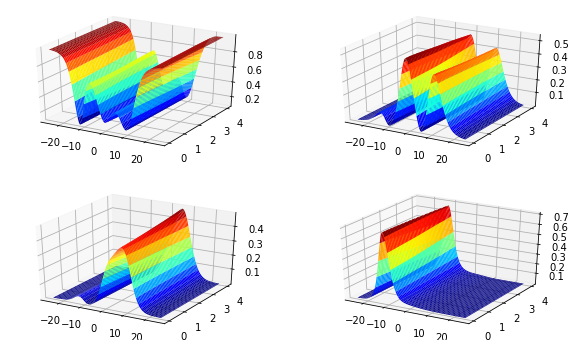

In [ ]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(221, projection='3d')

ax1.plot_surface(X, T, q1, cmap="jet")

ax2 = fig.add_subplot(222, projection='3d')

ax2.plot_surface(X, T, q2, cmap="jet")

ax3 = fig.add_subplot(223, projection='3d')

ax3.plot_surface(X, T, q3, cmap="jet")

ax4 = fig.add_subplot(224, projection='3d')

ax4.plot_surface(X, T, q4, cmap="jet")

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import MultipleLocator,FormatStrFormatter
from matplotlib.font_manager import FontProperties
import matplotlib.patheffects as PathEffects

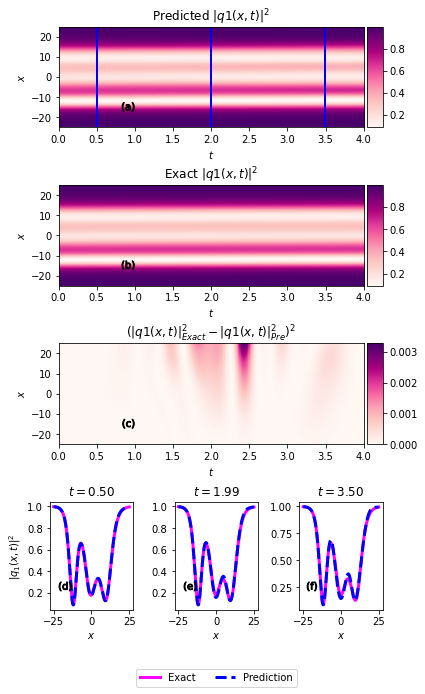

In [ ]:
fig, ax = plt.subplots(figsize=(6, 10))
ax.axis('off')


cmap_name = "RdPu"
####### Row 0: h(t,x) ##################    


#------------------------------------------------------------------
#-----------------------------predicted----------------------------
#------------------------------------------------------------------
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=0.8, left=0.15, right=0.9, wspace=0.2)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(q1.T, interpolation='nearest', cmap=cmap_name, 
            extent=[t_lower, t_upper, x_lower, x_upper], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('$t$')
#ax.set_xlim(0.0,4.99950249)
ax.set_ylabel('$x$')
ax.annotate("(a)", xy=(0.3, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')


line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[50]*np.ones((2,1)), line, 'b-', linewidth = 2)
ax.plot(t[199]*np.ones((2,1)), line, 'b-', linewidth = 2)
ax.plot(t[349]*np.ones((2,1)), line, 'b-', linewidth = 2)

#    plt.setp(leg.get_texts(), color='w')
ax.set_title('Predicted $|q1(x,t)|^2$')
#------------------------------------------------------------------
#-----------------------------Exact----------------------------
#------------------------------------------------------------------
gs2 = gridspec.GridSpec(1, 2)
gs2.update(top=0.72, bottom=0.58, left=0.15, right=0.9, wspace=0.2)
ax = plt.subplot(gs2[:, :])

h = ax.imshow((np.abs(q1_exact)**2).T, interpolation='nearest', cmap=cmap_name, 
            extent=[t_lower, t_upper, x_lower, x_upper], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('$t$')
#ax.set_xlim(0.02437811,4.99950249)
ax.set_ylabel('$x$')
ax.annotate("(b)", xy=(0.3, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')

ax.set_title('Exact $|q1(x,t)|^2$')
#------------------------------------------------------------------
#-----------------------------error----------------------------
#------------------------------------------------------------------
gs3 = gridspec.GridSpec(1, 2)
gs3.update(top=0.5, bottom=0.36, left=0.15, right=0.9, wspace=0.2)
ax = plt.subplot(gs3[:, :])

h = ax.imshow((q1-np.abs(q1_exact)**2)**2, interpolation='nearest', cmap=cmap_name, 
            extent=[t_lower, t_upper, x_lower, x_upper], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('$t$')
#ax.set_xlim(0.02437811,4.99950249)
ax.set_ylabel('$x$')
ax.annotate("(c)", xy=(0.3, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')

ax.set_title('$({|q1(x,t)|_{Exact}^2-|q1(x,t)|_{Pre}^2})^2$')
#--------------------------------------------------------------------"""




####### Row 2: h(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=0.28, bottom=0.13, left=0.13, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,np.abs(q1_exact[50,:])**2, c='magenta', ls='-', linewidth = 3, label = 'Exact')       
ax.plot(x,q1[50,:], 'b--', linewidth = 3, label = 'Prediction')
#ax.set_ylim(0.0,1.0)
ax.set_xlabel('$x$')
ax.set_ylabel('$|q_1(x,t)|^2$')    
ax.annotate("(d)", xy=(0.45, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')
ax.set_title('$t = %.2f$' % (t[50]))


ax = plt.subplot(gs1[0, 1])
ax.plot(x,np.abs(q1_exact[199,:])**2, c='magenta', ls='-', linewidth = 3, label = 'Exact')       
ax.plot(x,q1[199,:], 'b--', linewidth = 3, label = 'Prediction')
ax.set_xlabel('$x$')
#ax.set_ylim(0.0,1.0)
ax.annotate("(e)", xy=(0.45, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')
ax.set_title('$t = %.2f$' % (t[199]))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=5, frameon=True)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,np.abs(q1_exact[349,:])**2, c='magenta', ls='-', linewidth = 3, label = 'Exact')       
ax.plot(x,q1[349,:], 'b--', linewidth = 3, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_title('$t = %.2f$' % (t[349]))
#ax.set_ylim(0.0,1.0)
ax.annotate("(f)", xy=(0.4, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')


plt.savefig("4c-bec-q1.svg",dpi=600)
plt.savefig("4c-bec-q1.jpg",dpi=600)
plt.show()

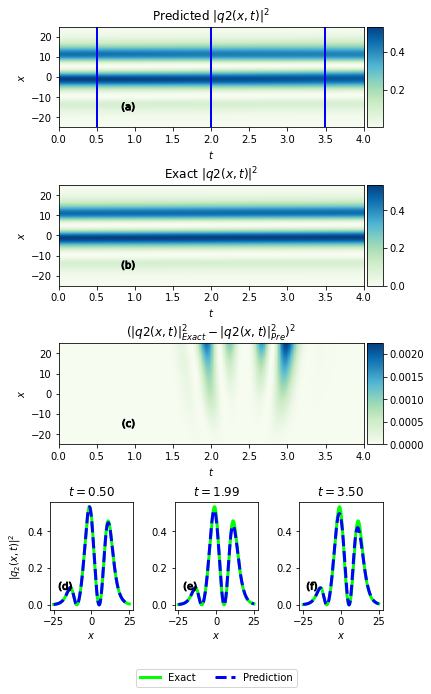

In [ ]:
fig, ax = plt.subplots(figsize=(6, 10))
ax.axis('off')


cmap_name = "GnBu"
####### Row 0: h(t,x) ##################    


#------------------------------------------------------------------
#-----------------------------predicted----------------------------
#------------------------------------------------------------------
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=0.8, left=0.15, right=0.9, wspace=0.2)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(q2.T, interpolation='nearest', cmap=cmap_name, 
            extent=[t_lower, t_upper, x_lower, x_upper], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('$t$')
#ax.set_xlim(0.0,4.99950249)
ax.set_ylabel('$x$')
ax.annotate("(a)", xy=(0.3, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')


line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[50]*np.ones((2,1)), line, 'b-', linewidth = 2)
ax.plot(t[199]*np.ones((2,1)), line, 'b-', linewidth = 2)
ax.plot(t[349]*np.ones((2,1)), line, 'b-', linewidth = 2)

#    plt.setp(leg.get_texts(), color='w')
ax.set_title('Predicted $|q2(x,t)|^2$')
#------------------------------------------------------------------
#-----------------------------Exact----------------------------
#------------------------------------------------------------------
gs2 = gridspec.GridSpec(1, 2)
gs2.update(top=0.72, bottom=0.58, left=0.15, right=0.9, wspace=0.2)
ax = plt.subplot(gs2[:, :])

h = ax.imshow((np.abs(q2_exact)**2).T, interpolation='nearest', cmap=cmap_name, 
            extent=[t_lower, t_upper, x_lower, x_upper], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('$t$')
#ax.set_xlim(0.02437811,4.99950249)
ax.set_ylabel('$x$')
ax.annotate("(b)", xy=(0.3, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')

ax.set_title('Exact $|q2(x,t)|^2$')
#------------------------------------------------------------------
#-----------------------------error----------------------------
#------------------------------------------------------------------
gs3 = gridspec.GridSpec(1, 2)
gs3.update(top=0.5, bottom=0.36, left=0.15, right=0.9, wspace=0.2)
ax = plt.subplot(gs3[:, :])

h = ax.imshow((q2-np.abs(q2_exact)**2)**2, interpolation='nearest', cmap=cmap_name, 
            extent=[t_lower, t_upper, x_lower, x_upper], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('$t$')
#ax.set_xlim(0.02437811,4.99950249)
ax.set_ylabel('$x$')
ax.annotate("(c)", xy=(0.3, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')

ax.set_title('$({|q2(x,t)|_{Exact}^2-|q2(x,t)|_{Pre}^2})^2$')
#--------------------------------------------------------------------"""




####### Row 2: h(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=0.28, bottom=0.13, left=0.13, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,np.abs(q2_exact[50,:])**2, c='lime', ls='-', linewidth = 3, label = 'Exact')       
ax.plot(x,q2[50,:], 'b--', linewidth = 3, label = 'Prediction')
#ax.set_ylim(0.0,1.0)
ax.set_xlabel('$x$')
ax.set_ylabel('$|q_2(x,t)|^2$')    
ax.annotate("(d)", xy=(0.45, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')
ax.set_title('$t = %.2f$' % (t[50]))


ax = plt.subplot(gs1[0, 1])
ax.plot(x,np.abs(q2_exact[199,:])**2, c='lime', ls='-', linewidth = 3, label = 'Exact')       
ax.plot(x,q2[199,:], 'b--', linewidth = 3, label = 'Prediction')
ax.set_xlabel('$x$')
#ax.set_ylim(0.0,1.0)
ax.annotate("(e)", xy=(0.45, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')
ax.set_title('$t = %.2f$' % (t[199]))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=5, frameon=True)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,np.abs(q2_exact[349,:])**2, c='lime', ls='-', linewidth = 3, label = 'Exact')       
ax.plot(x,q2[349,:], 'b--', linewidth = 3, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_title('$t = %.2f$' % (t[349]))
#ax.set_ylim(0.0,1.0)
ax.annotate("(f)", xy=(0.4, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')


plt.savefig("4c-bec-q2.svg",dpi=600)
plt.savefig("4c-bec-q2.jpg",dpi=600)
plt.show()

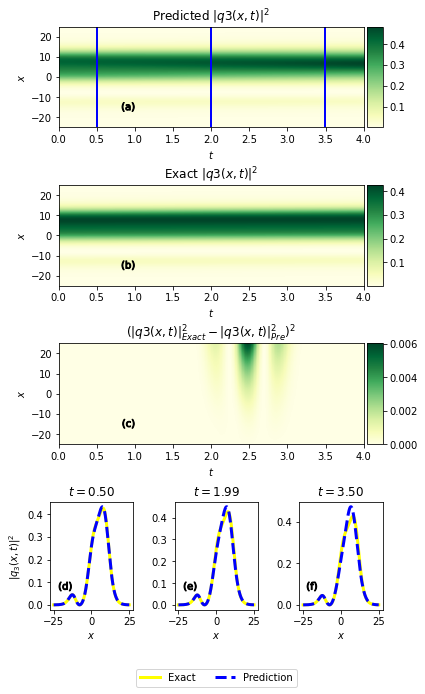

In [ ]:
fig, ax = plt.subplots(figsize=(6, 10))
ax.axis('off')


cmap_name = "YlGn"
####### Row 0: h(t,x) ##################    


#------------------------------------------------------------------
#-----------------------------predicted----------------------------
#------------------------------------------------------------------
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=0.8, left=0.15, right=0.9, wspace=0.2)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(q3.T, interpolation='nearest', cmap=cmap_name, 
            extent=[t_lower, t_upper, x_lower, x_upper], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('$t$')
#ax.set_xlim(0.0,4.99950249)
ax.set_ylabel('$x$')
ax.annotate("(a)", xy=(0.3, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')


line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[50]*np.ones((2,1)), line, 'b-', linewidth = 2)
ax.plot(t[199]*np.ones((2,1)), line, 'b-', linewidth = 2)
ax.plot(t[349]*np.ones((2,1)), line, 'b-', linewidth = 2)

#    plt.setp(leg.get_texts(), color='w')
ax.set_title('Predicted $|q3(x,t)|^2$')
#------------------------------------------------------------------
#-----------------------------Exact----------------------------
#------------------------------------------------------------------
gs2 = gridspec.GridSpec(1, 2)
gs2.update(top=0.72, bottom=0.58, left=0.15, right=0.9, wspace=0.2)
ax = plt.subplot(gs2[:, :])

h = ax.imshow((np.abs(q3_exact)**2).T, interpolation='nearest', cmap=cmap_name, 
            extent=[t_lower, t_upper, x_lower, x_upper], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('$t$')
#ax.set_xlim(0.02437811,4.99950249)
ax.set_ylabel('$x$')
ax.annotate("(b)", xy=(0.3, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')

ax.set_title('Exact $|q3(x,t)|^2$')
#------------------------------------------------------------------
#-----------------------------error----------------------------
#------------------------------------------------------------------
gs3 = gridspec.GridSpec(1, 2)
gs3.update(top=0.5, bottom=0.36, left=0.15, right=0.9, wspace=0.2)
ax = plt.subplot(gs3[:, :])

h = ax.imshow((q3-np.abs(q3_exact)**2)**2, interpolation='nearest', cmap=cmap_name, 
            extent=[t_lower, t_upper, x_lower, x_upper], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('$t$')
#ax.set_xlim(0.02437811,4.99950249)
ax.set_ylabel('$x$')
ax.annotate("(c)", xy=(0.3, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')

ax.set_title('$({|q3(x,t)|_{Exact}^2-|q3(x,t)|_{Pre}^2})^2$')
#--------------------------------------------------------------------"""




####### Row 2: h(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=0.28, bottom=0.13, left=0.13, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,np.abs(q3_exact[50,:])**2, c='yellow', ls='-', linewidth = 3, label = 'Exact')       
ax.plot(x,q3[50,:], 'b--', linewidth = 3, label = 'Prediction')
#ax.set_ylim(0.0,1.0)
ax.set_xlabel('$x$')
ax.set_ylabel('$|q_3(x,t)|^2$')    
ax.annotate("(d)", xy=(0.45, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')
ax.set_title('$t = %.2f$' % (t[50]))


ax = plt.subplot(gs1[0, 1])
ax.plot(x,np.abs(q3_exact[199,:])**2, c='yellow', ls='-', linewidth = 3, label = 'Exact')       
ax.plot(x,q3[199,:], 'b--', linewidth = 3, label = 'Prediction')
ax.set_xlabel('$x$')
#ax.set_ylim(0.0,1.0)
ax.annotate("(e)", xy=(0.45, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')
ax.set_title('$t = %.2f$' % (t[199]))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=5, frameon=True)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,np.abs(q3_exact[349,:])**2, c='yellow', ls='-', linewidth = 3, label = 'Exact')       
ax.plot(x,q3[349,:], 'b--', linewidth = 3, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_title('$t = %.2f$' % (t[349]))
#ax.set_ylim(0.0,1.0)
ax.annotate("(f)", xy=(0.4, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')


plt.savefig("4c-bec-q3.svg",dpi=600)
plt.savefig("4c-bec-q3.jpg",dpi=600)
plt.show()

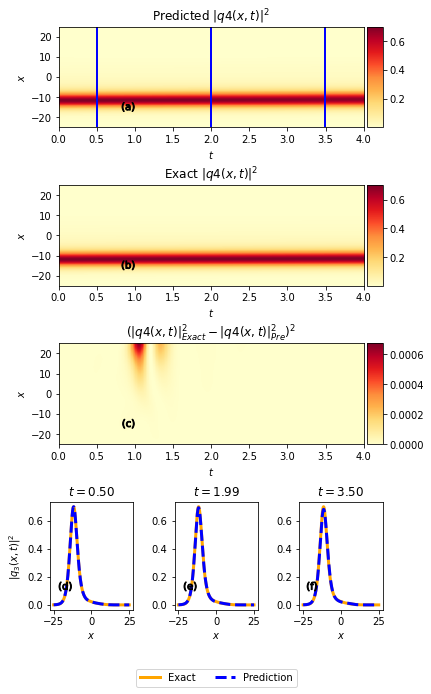

In [ ]:
fig, ax = plt.subplots(figsize=(6, 10))
ax.axis('off')


cmap_name = "YlOrRd"
####### Row 0: h(t,x) ##################    


#------------------------------------------------------------------
#-----------------------------predicted----------------------------
#------------------------------------------------------------------
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=0.8, left=0.15, right=0.9, wspace=0.2)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(q4.T, interpolation='nearest', cmap=cmap_name, 
            extent=[t_lower, t_upper, x_lower, x_upper], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('$t$')
#ax.set_xlim(0.0,4.99950249)
ax.set_ylabel('$x$')
ax.annotate("(a)", xy=(0.3, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')


line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[50]*np.ones((2,1)), line, 'b-', linewidth = 2)
ax.plot(t[199]*np.ones((2,1)), line, 'b-', linewidth = 2)
ax.plot(t[349]*np.ones((2,1)), line, 'b-', linewidth = 2)

#    plt.setp(leg.get_texts(), color='w')
ax.set_title('Predicted $|q4(x,t)|^2$')
#------------------------------------------------------------------
#-----------------------------Exact----------------------------
#------------------------------------------------------------------
gs2 = gridspec.GridSpec(1, 2)
gs2.update(top=0.72, bottom=0.58, left=0.15, right=0.9, wspace=0.2)
ax = plt.subplot(gs2[:, :])

h = ax.imshow((np.abs(q4_exact)**2).T, interpolation='nearest', cmap=cmap_name, 
            extent=[t_lower, t_upper, x_lower, x_upper], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('$t$')
#ax.set_xlim(0.02437811,4.99950249)
ax.set_ylabel('$x$')
ax.annotate("(b)", xy=(0.3, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')

ax.set_title('Exact $|q4(x,t)|^2$')
#------------------------------------------------------------------
#-----------------------------error----------------------------
#------------------------------------------------------------------
gs3 = gridspec.GridSpec(1, 2)
gs3.update(top=0.5, bottom=0.36, left=0.15, right=0.9, wspace=0.2)
ax = plt.subplot(gs3[:, :])

h = ax.imshow((q4-np.abs(q4_exact)**2)**2, interpolation='nearest', cmap=cmap_name, 
            extent=[t_lower, t_upper, x_lower, x_upper], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_xlabel('$t$')
#ax.set_xlim(0.02437811,4.99950249)
ax.set_ylabel('$x$')
ax.annotate("(c)", xy=(0.3, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')

ax.set_title('$({|q4(x,t)|_{Exact}^2-|q4(x,t)|_{Pre}^2})^2$')
#--------------------------------------------------------------------"""




####### Row 2: h(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=0.28, bottom=0.13, left=0.13, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,np.abs(q4_exact[50,:])**2, c='orange', ls='-', linewidth = 3, label = 'Exact')       
ax.plot(x,q4[50,:], 'b--', linewidth = 3, label = 'Prediction')
#ax.set_ylim(0.0,1.0)
ax.set_xlabel('$x$')
ax.set_ylabel('$|q_3(x,t)|^2$')    
ax.annotate("(d)", xy=(0.45, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')
ax.set_title('$t = %.2f$' % (t[50]))


ax = plt.subplot(gs1[0, 1])
ax.plot(x,np.abs(q4_exact[199,:])**2, c='orange', ls='-', linewidth = 3, label = 'Exact')       
ax.plot(x,q4[199,:], 'b--', linewidth = 3, label = 'Prediction')
ax.set_xlabel('$x$')
#ax.set_ylim(0.0,1.0)
ax.annotate("(e)", xy=(0.45, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')
ax.set_title('$t = %.2f$' % (t[199]))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=5, frameon=True)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,np.abs(q4_exact[349,:])**2, c='orange', ls='-', linewidth = 3, label = 'Exact')       
ax.plot(x,q4[349,:], 'b--', linewidth = 3, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_title('$t = %.2f$' % (t[349]))
#ax.set_ylim(0.0,1.0)
ax.annotate("(f)", xy=(0.4, 0.4), xycoords='axes fraction', fontsize='medium',
       xytext=(-15, -15), textcoords='offset points', color='k',
       path_effects=[PathEffects.withStroke(linewidth=1, foreground='k')],
       horizontalalignment='right', verticalalignment='top')


plt.savefig("4c-bec-q4.svg",dpi=600)
plt.savefig("4c-bec-q4.jpg",dpi=600)
plt.show()

In [ ]:
np.savetxt('4c_bec_u_pre.dat',U_pred)
np.savetxt('4c_bec_v_pre.dat',V_pred)

np.savetxt('4c_bec_p_pre.dat',P_pred)
np.savetxt('4c_bec_s_pre.dat',S_pred)

np.savetxt('4c_bec_a_pre.dat',A_pred)
np.savetxt('4c_bec_b_pre.dat',B_pred)

np.savetxt('4c_bec_c_pre.dat',C_pred)
np.savetxt('4c_bec_d_pre.dat',D_pred)

np.savetxt('4c_bec_q1_pre.dat',q1)
np.savetxt('4c_bec_q2_pre.dat',q2)
np.savetxt('4c_bec_q3_pre.dat',q3)
np.savetxt('4c_bec_q4_pre.dat',q4)


In [ ]:
np.savetxt('4c_bec_u_ori.dat',Exact_u)
np.savetxt('4c_bec_v_ori.dat',Exact_v)

np.savetxt('4c_bec_p_ori.dat',Exact_p)
np.savetxt('4c_bec_s_ori.dat',Exact_s)

np.savetxt('4c_bec_a_ori.dat',Exact_a)
np.savetxt('4c_bec_b_ori.dat',Exact_b)

np.savetxt('4c_bec_c_ori.dat',Exact_c)
np.savetxt('4c_bec_d_ori.dat',Exact_d)

np.savetxt('4c_bec_q1_ori.dat',np.abs(q1_exact)**2)
np.savetxt('4c_bec_q2_ori.dat',np.abs(q2_exact)**2)
np.savetxt('4c_bec_q3_ori.dat',np.abs(q3_exact)**2)
np.savetxt('4c_bec_q4_ori.dat',np.abs(q4_exact)**2)


In [ ]:
np.savetxt('4c_bec_x.dat', x)
np.savetxt('4c_bec_t.dat', t)
np.savetxt('4c_bec_boundary.dat', X_u_train_bc)
np.savetxt('4c_bec_initial.dat', X_u_train_ic)
np.savetxt('4c_bec_collocation.dat', X_f_train_lhs)

In [ ]:
X_f_train_lhs.shape

(20000, 2)

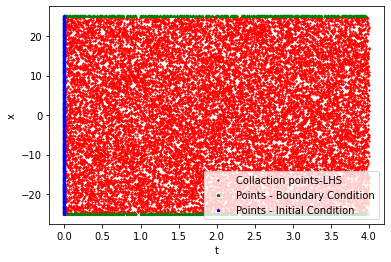

In [ ]:
plt.scatter(X_f_train_lhs[:, 1], X_f_train_lhs[:, 0], marker='*', c='red', s=2, label='Collaction points-LHS')
plt.scatter(X_u_train_bc[:, 1], X_u_train_bc[:, 0], marker='*', c='green', s=8, label='Points - Boundary Condition')
plt.scatter(X_u_train_ic[:, 1], X_u_train_ic[:, 0], marker='*', c='blue', s=8, label='Points - Initial Condition')
plt.xlabel('t')
plt.ylabel('x')
plt.legend(loc='best')

plt.savefig("4c-bec-points.svg",dpi=600)
plt.savefig("4c-bec-points.jpg",dpi=600)
plt.show()

In [ ]:
!zip -r /content/BEC_4c_torch.zip /content/

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2022.10.07/ (stored 0%)
  adding: content/.config/logs/2022.10.07/13.34.26.675197.log (deflated 53%)
  adding: content/.config/logs/2022.10.07/13.34.17.754134.log (deflated 86%)
  adding: content/.config/logs/2022.10.07/13.34.49.852351.log (deflated 55%)
  adding: content/.config/logs/2022.10.07/13.33.29.962578.log (deflated 91%)
  adding: content/.config/logs/2022.10.07/13.34.50.628315.log (deflated 53%)
  adding: content/.config/logs/2022.10.07/13.33.55.059309.log (deflated 53%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)

In [ ]:
from google.colab import files
files.download('BEC_4c_torch.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>